# Reanalysis climatology

In [1]:
import sys
import os
import glob
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from matplotlib.gridspec import GridSpec
sys.path.append('/g/data/qz03/wp3/code/git-repo')
from utils import *

In [2]:
import warnings
import logging
warnings.filterwarnings('ignore') 
logging.getLogger("distributed.worker.memory").setLevel(logging.ERROR)
logging.getLogger('flox').setLevel(logging.WARNING)

In [3]:
import dask
import tempfile
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster

dask.config.set({
    'array.chunk-size': "256 MiB",
    'array.slicing.split_large_chunks': True, #This can make AXIOM very slow
    'distributed.comm.timeouts.connect': '120s',
    'distributed.comm.timeouts.tcp': '120s',
    'distributed.comm.retry.count': 10,
    'distributed.scheduler.allowed-failures': 20,
    "distributed.scheduler.worker-saturation": 1.1, #This should use the new behaviour which helps with memory pile up
})

# client = dask.distributed.Client()
client = Client(n_workers=10, threads_per_worker=1, local_directory = tempfile.mkdtemp(), memory_limit = "63000mb")
client

<Client: 'tcp://127.0.0.1:40709' processes=10 threads=10, memory=586.73 GiB>

2025-11-20 13:36:43,155 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:37765' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {'_finalize_store-090e1b8b-a52c-4d87-9375-93e5d2b5e65a'} (stimulus_id='handle-worker-cleanup-1763606203.15578')


## Load in reanalysis grids

In [4]:
%%time
barra_uas_hly = xr.open_mfdataset(glob.glob('/g/data/qz03/wp3/data/reanalysis/BARRAR2/1hr/uas/*.nc'),combine='nested', concat_dim='time',parallel=True, engine='netcdf4')
barra_vas_hly = xr.open_mfdataset(glob.glob('/g/data/qz03/wp3/data/reanalysis/BARRAR2/1hr/vas/*.nc'),combine='nested', concat_dim='time',parallel=True, engine='netcdf4')
barra_u100_hly = xr.open_mfdataset(glob.glob('/g/data/qz03/wp3/data/reanalysis/BARRAR2/1hr/ua100m/*.nc'),combine='nested', concat_dim='time',parallel=True, engine='netcdf4')
barra_v100_hly = xr.open_mfdataset(glob.glob('/g/data/qz03/wp3/data/reanalysis/BARRAR2/1hr/va100m/*.nc'),combine='nested', concat_dim='time',parallel=True, engine='netcdf4')
barra_pr_hly = xr.open_mfdataset(glob.glob('/g/data/qz03/wp3/data/reanalysis/BARRAR2/1hr/pr/*.nc'),combine='nested', concat_dim='time',parallel=True, engine='netcdf4')
barra_rsds_hly = xr.open_mfdataset(glob.glob('/g/data/qz03/wp3/data/reanalysis/BARRAR2/1hr/rsds/*.nc'),combine='nested', concat_dim='time',parallel=True, engine='netcdf4')
barra_rsds_dly = xr.open_mfdataset(glob.glob('/g/data/qz03/wp3/data/reanalysis/BARRAR2/day/rsds/*.nc'),combine='nested', concat_dim='time',parallel=True, engine='netcdf4')

era5_uas_hly = xr.open_mfdataset(glob.glob('/g/data/qz03/wp3/data/reanalysis/ERA5/10u/*.nc'),combine='nested', concat_dim='time',parallel=True, engine='netcdf4').rename({'latitude': 'lat'}).rename({'longitude': 'lon'})
era5_vas_hly = xr.open_mfdataset(glob.glob('/g/data/qz03/wp3/data/reanalysis/ERA5/10v/*.nc'),combine='nested', concat_dim='time',parallel=True, engine='netcdf4').rename({'latitude': 'lat'}).rename({'longitude': 'lon'})
era5_u100_hly = xr.open_mfdataset(glob.glob('/g/data/qz03/wp3/data/reanalysis/ERA5/100u/*.nc'),combine='nested', concat_dim='time',parallel=True, engine='netcdf4').rename({'latitude': 'lat'}).rename({'longitude': 'lon'})
era5_v100_hly = xr.open_mfdataset(glob.glob('/g/data/qz03/wp3/data/reanalysis/ERA5/100v/*.nc'),combine='nested', concat_dim='time',parallel=True, engine='netcdf4').rename({'latitude': 'lat'}).rename({'longitude': 'lon'})
era5_pr_hly = xr.open_mfdataset(glob.glob('/g/data/qz03/wp3/data/reanalysis/ERA5/tp/*.nc'),combine='nested', concat_dim='time',parallel=True, engine='netcdf4').rename({'latitude': 'lat'}).rename({'longitude': 'lon'})
era5_rsds_hly = xr.open_mfdataset(glob.glob('/g/data/qz03/wp3/data/reanalysis/ERA5/ssrd/*.nc'),combine='nested', concat_dim='time',parallel=True, engine='netcdf4').rename({'latitude': 'lat'}).rename({'longitude': 'lon'})


CPU times: user 9.12 s, sys: 3.21 s, total: 12.3 s
Wall time: 20.8 s


### Windspeed climatologies

In [5]:
def plot_climo(plot_type, input_climo_xr, plot_var, cmap, vmin, vmax, cbar_extend, cbar_label, plot_title):
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    sys.path.append('/g/data/qz03/wp3/code/git-repo')
    from utils import domain_dict
    
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
    plot_array = input_climo_xr[plot_var]
    
    contour = plot_array.plot.imshow(ax=ax, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), cmap=cmap, add_colorbar=False) if plot_type =='raster' else plot_array.plot.contourf(ax=ax, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), cmap=cmap, levels=((vmax-vmin)*2)+1, add_colorbar=False)
    cbar = fig.colorbar(contour, ax=ax, orientation='horizontal', pad=0.05, fraction=0.07, shrink=0.6, extend=cbar_extend, label=cbar_label)
    
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.set_title(plot_title, fontsize=14, pad=12)
    ax.set_extent([domain_dict['indonesia']['lon_min'], domain_dict['indonesia']['lon_max'], domain_dict['indonesia']['lat_min'], domain_dict['indonesia']['lat_max']], crs=ccrs.PlateCarree())
    
    plt.tight_layout()
    plt.show()
    return

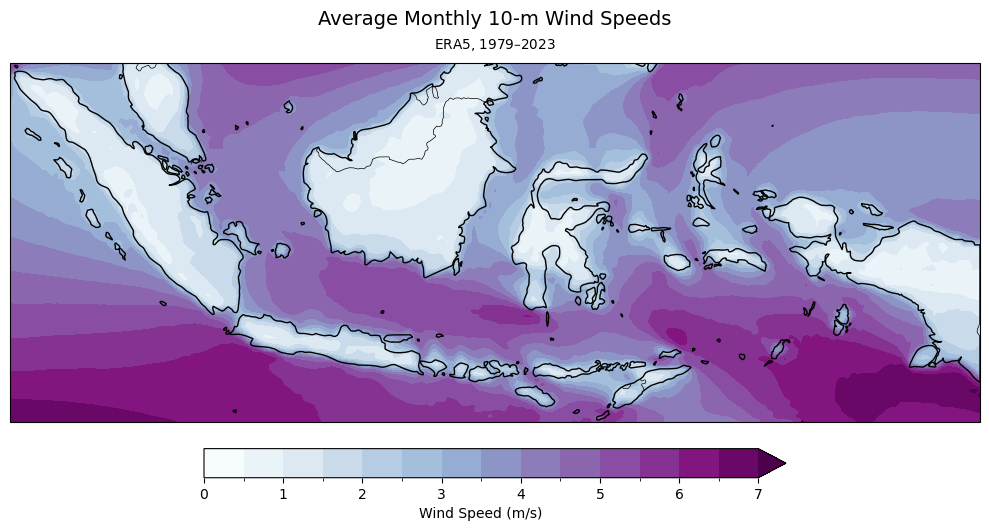

CPU times: user 1min 23s, sys: 7.17 s, total: 1min 31s
Wall time: 2min 1s


In [6]:
%%time
era5_ws10_hly = (era5_vas_hly.v10**2 + era5_uas_hly.u10**2) ** 0.5
era5_ws10_dly = (era5_ws10_hly.sortby("time")).resample(time='D').mean()
era5_ws10_dly = era5_ws10_dly.chunk({'time':720, 'lat':'auto', 'lon':'auto'}).compute()
plot_climo('contour', xr.Dataset({'ws10': ((era5_ws10_dly.resample(time='1M')).mean()).mean(dim='time')}), 'ws10', 'BuPu', 0, 7, 'max', 'Wind Speed (m/s)', 'Average Monthly 10-m Wind Speeds\n$_{\\text{ERA5, 1979–2023}}$')

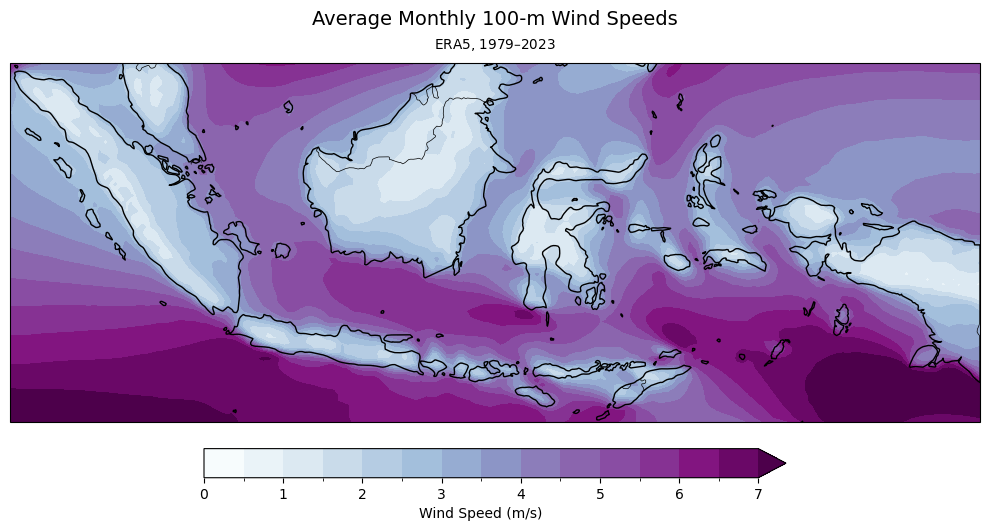

CPU times: user 1min 27s, sys: 6.84 s, total: 1min 34s
Wall time: 2min 8s


In [7]:
%%time
era5_ws100_hly = (era5_v100_hly.v100**2 + era5_u100_hly.u100**2) ** 0.5
era5_ws100_dly = (era5_ws100_hly.sortby("time")).resample(time='D').mean()
era5_ws100_dly = era5_ws100_dly.chunk({'time':720, 'lat':'auto', 'lon':'auto'}).compute()
plot_climo('contour', xr.Dataset({'ws100': ((era5_ws100_dly.resample(time='1M')).mean()).mean(dim='time')}), 'ws100', 'BuPu', 0, 7, 'max', 'Wind Speed (m/s)', 'Average Monthly 100-m Wind Speeds\n$_{\\text{ERA5, 1979–2023}}$')

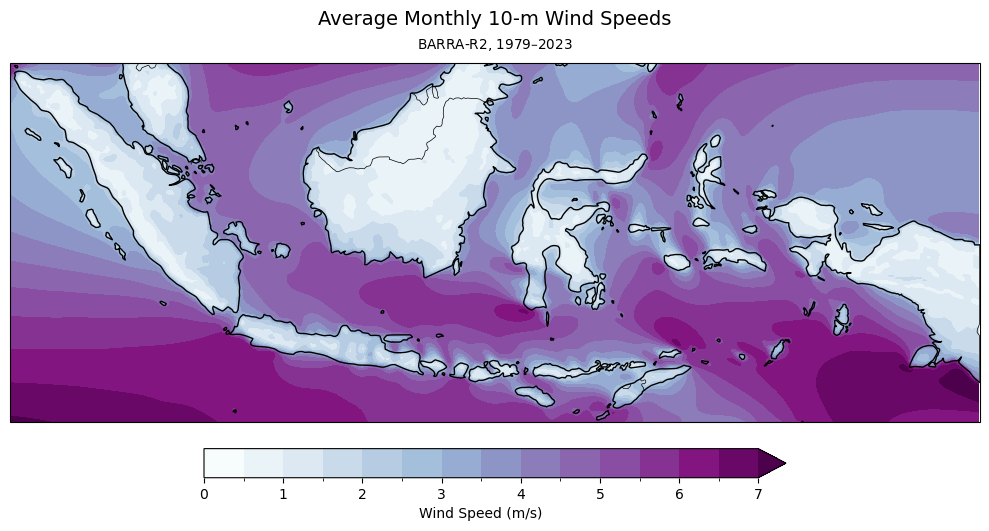

CPU times: user 4min 28s, sys: 29.1 s, total: 4min 57s
Wall time: 7min 2s


In [8]:
%%time
barra_ws10_hly = (barra_vas_hly.sortby("time").vas**2 + barra_uas_hly.sortby("time").uas**2) ** 0.5
barra_ws10_dly = (barra_ws10_hly.sortby("time")).resample(time='D').mean()
barra_ws10_dly = barra_ws10_dly.chunk({'time':720, 'lat':'auto', 'lon':'auto'}).compute()
plot_climo('contour', xr.Dataset({'ws10': ((barra_ws10_dly.resample(time='1M')).mean()).mean(dim='time')}), 'ws10', 'BuPu', 0, 7, 'max', 'Wind Speed (m/s)', 'Average Monthly 10-m Wind Speeds\n$_{\\text{BARRA-R2, 1979–2023}}$')

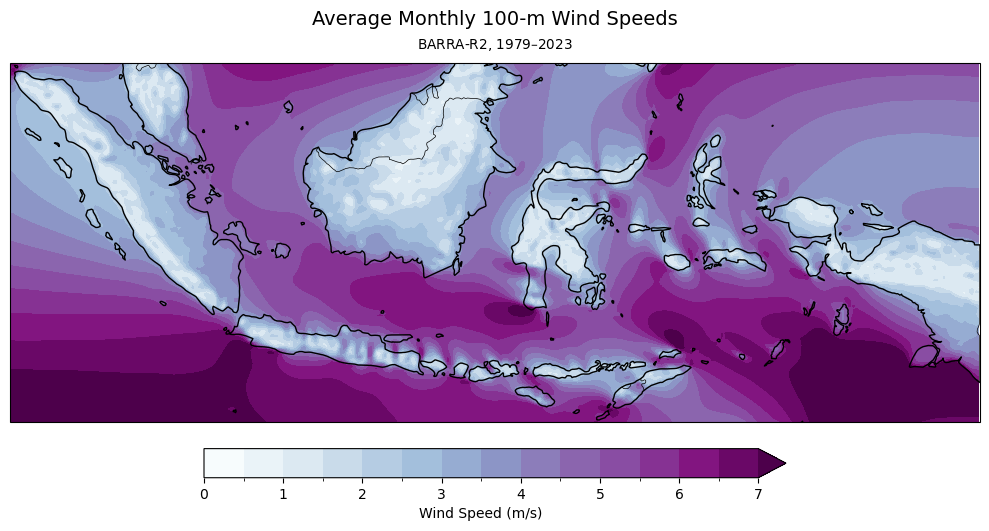

CPU times: user 5min 18s, sys: 2min 7s, total: 7min 26s
Wall time: 9min 52s


In [6]:
%%time
barra_ws100_hly = (barra_v100_hly.sortby("time").va100m**2 + barra_u100_hly.sortby("time").ua100m**2) ** 0.5
barra_ws100_dly = (barra_ws100_hly.sortby("time")).resample(time='D').mean()
barra_ws100_dly = barra_ws100_dly.chunk({'time':720, 'lat':'auto', 'lon':'auto'}).compute()
barra_ws100_mthly = xr.Dataset({'ws100': ((barra_ws100_dly.resample(time='1M')).mean()).mean(dim='time')})

plot_climo('contour', xr.Dataset({'ws100': ((barra_ws100_dly.resample(time='1M')).mean()).mean(dim='time')}), 'ws100', 'BuPu', 0, 7, 'max', 'Wind Speed (m/s)', 'Average Monthly 100-m Wind Speeds\n$_{\\text{BARRA-R2, 1979–2023}}$')

### Hours above threshold

In [7]:
def compute_percentile(base_period, percentile_threshold):
    """Compute percentiles across the time axis"""
    percentile_array = base_period.quantile(percentile_threshold/100, dim='time')
    return percentile_array


In [13]:
%%time
p_thresh = 75
input_array = barra_ws100_dly.astype(np.float32).chunk({'time':-1})
ds_perc = input_array.groupby(barra_ws100_dly['time'].dt.dayofyear).map(lambda x: compute_percentile(x, p_thresh))
ds_perc = ds_perc.rename('p{}_ws100'.format(p_thresh))

CPU times: user 5.37 s, sys: 5.31 s, total: 10.7 s
Wall time: 8.89 s


In [16]:
%%time
saver = ds_perc.to_netcdf('/g/data/qz03/wp3/data/p75trial.nc',compute=False)
future = client.persist(saver)
dask.distributed.progress(future)
future.compute()

CPU times: user 14.8 s, sys: 7.27 s, total: 22.1 s
Wall time: 1min 2s


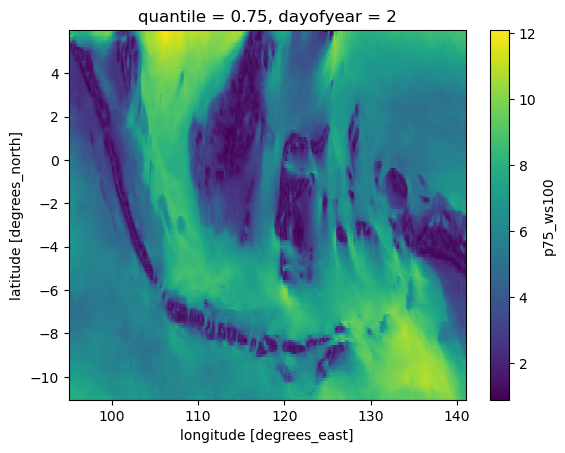

In [18]:
xr.open_dataset('/g/data/qz03/wp3/data/p75trial.nc')['p75_ws100'][1].plot()

### Multiplots

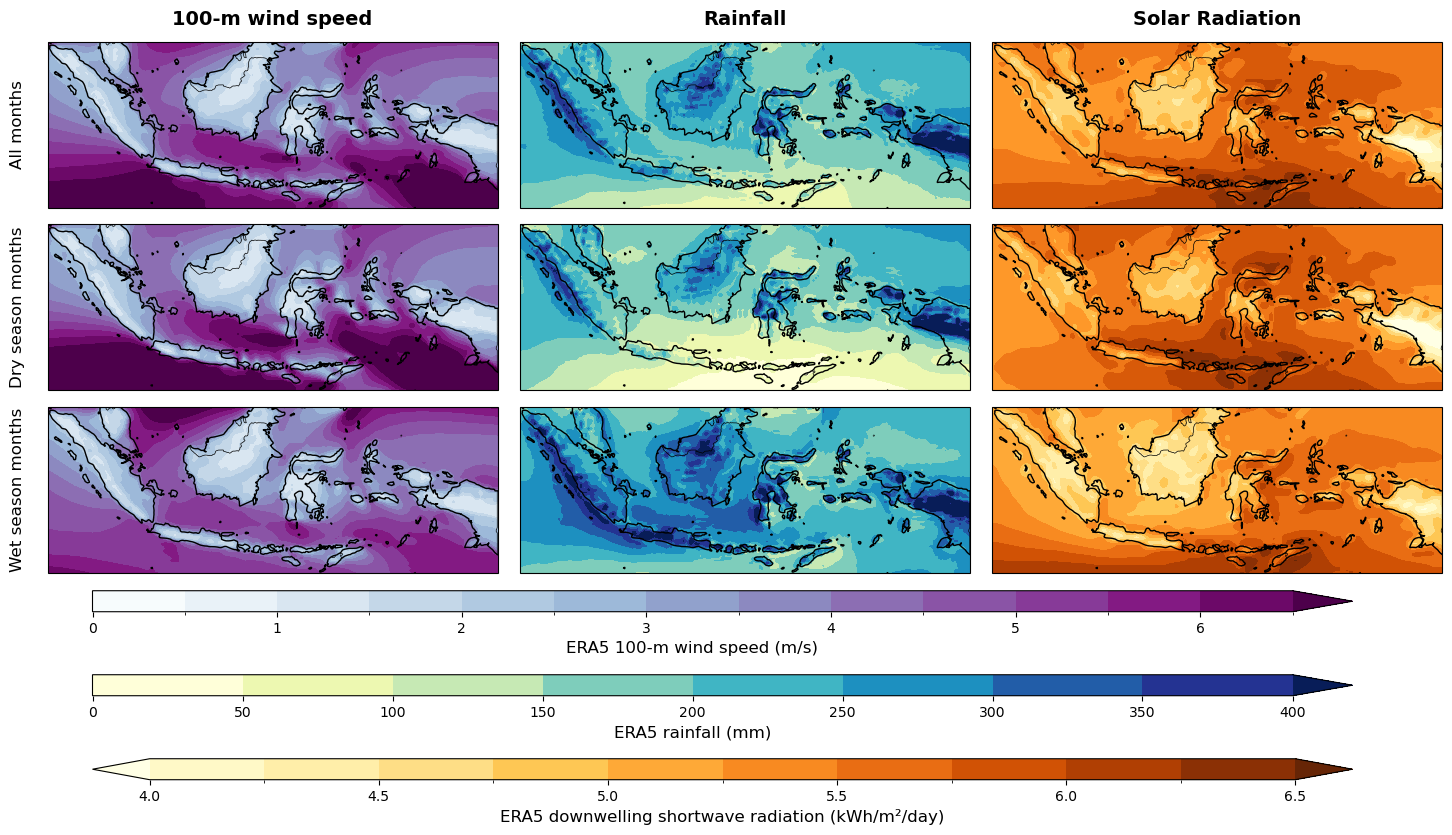

<Figure size 640x480 with 0 Axes>

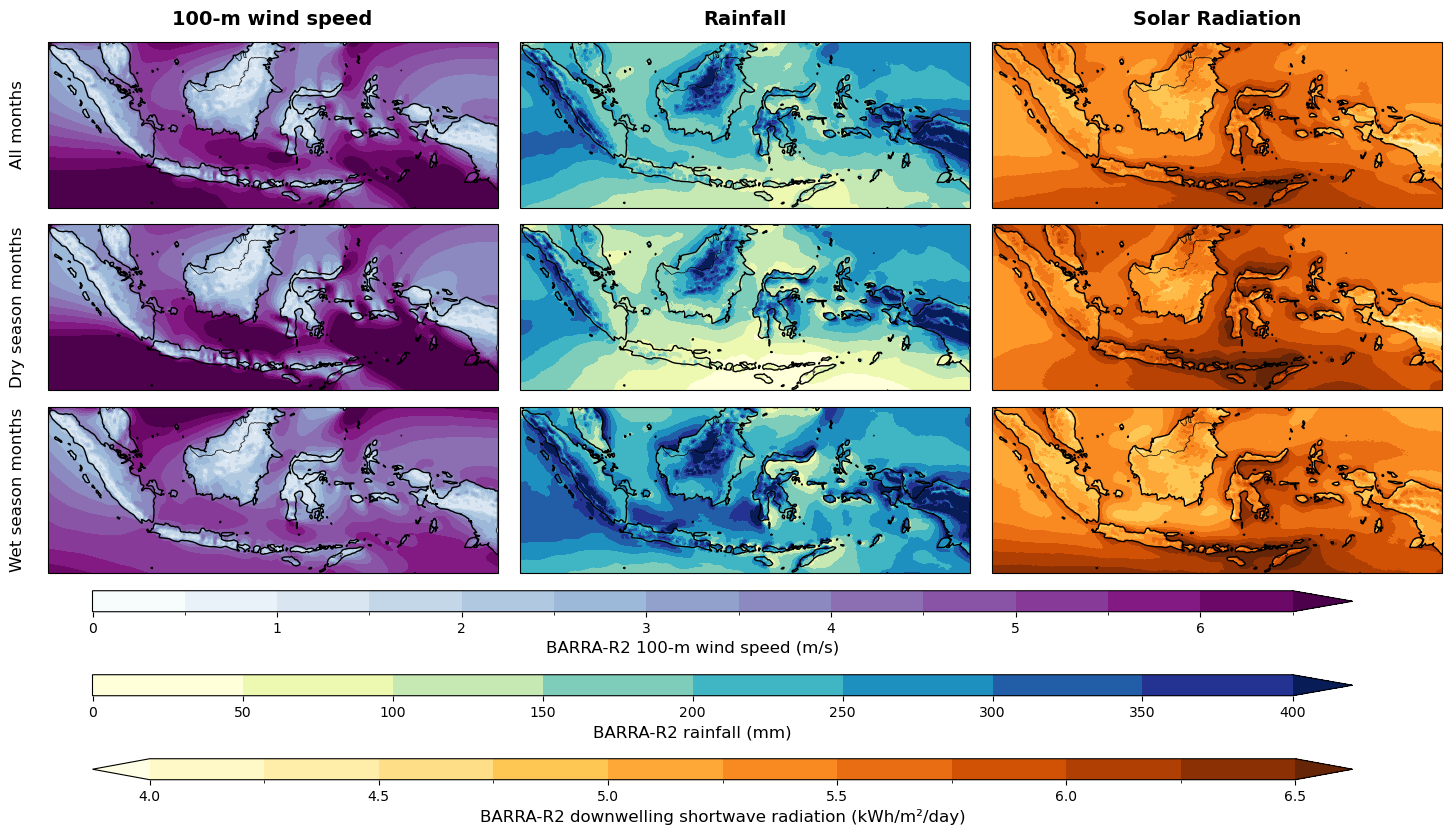

CPU times: user 9min 54s, sys: 50 s, total: 10min 44s
Wall time: 12min 49s


<Figure size 640x480 with 0 Axes>

In [12]:
%%time
for plot_source in ['ERA5', 'BARRA-R2']:
    ws10 = xr.Dataset({'ws10': (barra_ws10_hly.resample(time='1M')).mean()}) if plot_source == 'BARRA-R2' else xr.Dataset({'ws10': (era5_ws10_dly.resample(time='1M')).mean()})
    ws100 = xr.Dataset({'ws100': (barra_ws100_hly.resample(time='1M')).mean()}) if plot_source == 'BARRA-R2' else xr.Dataset({'ws100': (era5_ws100_dly.resample(time='1M')).mean()})
    pr = xr.Dataset({'pr': (barra_pr_hly.pr.sortby("time")*3600).resample(time='1M').sum()}) if plot_source == 'BARRA-R2' else xr.Dataset({'pr': (era5_pr_hly.tp.sortby("time")*1000).resample(time='1M').sum()}) 
    ghi = xr.Dataset({'ghi': ((barra_rsds_dly.rsds*0.024).sortby('time'))}) if plot_source == 'BARRA-R2' else xr.Dataset({'ghi': (era5_rsds_hly.ssrd.sortby("time")/(3.6e6)).resample(time='D').sum()}) #GHI units = kWh/m2 BARRA units = W/m2 #ERA5 units = J/m2
    
    climo_dict = {}
    climo_dict['All_months-100-m_winds'] = ws100.mean(dim='time')
    climo_dict['Dry_season_months-100-m_winds'] = ws100.sel(time=ws100.time.dt.month.isin([4, 5, 6, 7, 8, 9, 10])).mean('time')
    climo_dict['Wet_season_months-100-m_winds'] = ws100.sel(time=ws100.time.dt.month.isin([11, 12, 1, 2, 3])).mean('time')

    # climo_dict['All_months-10-m_winds'] = ws10.mean(dim='time')
    # climo_dict['Dry_season_months-10-m_winds'] = ws10.sel(time=ws10.time.dt.month.isin([4, 5, 6, 7, 8, 9, 10])).mean('time')
    # climo_dict['Wet_season_months-10-m_winds'] = ws10.sel(time=ws10.time.dt.month.isin([11, 12, 1, 2, 3])).mean('time')

    climo_dict['All_months_months-rainfall'] = pr.mean(dim='time')
    climo_dict['Dry_season_months-rainfall'] = pr.sel(time=pr.time.dt.month.isin([4, 5, 6, 7, 8, 9, 10])).mean('time')
    climo_dict['Wet_season_months-rainfall'] = pr.sel(time=pr.time.dt.month.isin([11, 12, 1, 2, 3])).mean('time')
    
    climo_dict['All_months-surface_downwelling_radiation'] = ghi.mean(dim='time')
    climo_dict['Dry_season_months-surface_downwelling_radiation'] = ghi.sel(time=ghi.time.dt.month.isin([4, 5, 6, 7, 8, 9, 10])).mean('time')
    climo_dict['Wet_season_months-surface_downwelling_radiation'] = ghi.sel(time=ghi.time.dt.month.isin([11, 12, 1, 2, 3])).mean('time')

    fig = plt.figure(figsize=(18, 7))
    gs = GridSpec(3, 3, figure=fig, hspace=0.05, wspace=0.05)
    axes = [fig.add_subplot(gs[i, j], projection=ccrs.PlateCarree()) for i in range(3) for j in range(3)]
    
    season_order = ['All_months', 'Dry_season_months', 'Wet_season_months']
    var_order = ['100-m_winds', 'rainfall', 'surface_downwelling_radiation']
    ordered_keys = []
    for season in season_order:
        for var in var_order:
            for key in climo_dict.keys():
                if season in key and var in key:
                    ordered_keys.append(key)

    for ax, key in zip(axes, ordered_keys):
        plot_data = climo_dict[key]

        if '100-m_winds' in key:
            wind100m = plot_data.ws100.plot.contourf(ax=ax, vmin=0, vmax=6.5, levels=14, transform=ccrs.PlateCarree(), cmap='BuPu', add_colorbar=False)    
        elif 'rainfall' in key:
            rain = plot_data.pr.plot.contourf(ax=ax, vmin=0, vmax=400, levels=9, transform=ccrs.PlateCarree(), cmap='YlGnBu', add_colorbar=False)    
        elif 'radiation' in key:
            rsds = plot_data.ghi.plot.contourf(ax=ax, vmin=4, vmax=6.5, levels=11, transform=ccrs.PlateCarree(), cmap='YlOrBr', add_colorbar=False)    
    
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax.set_extent([domain_dict['indonesia']['lon_min'], domain_dict['indonesia']['lon_max'],
                       domain_dict['indonesia']['lat_min'], domain_dict['indonesia']['lat_max']], crs=ccrs.PlateCarree())
        ax.set_title('')

    col_labels = ['100-m wind speed', 'Rainfall', 'Solar Radiation']
    for j in range(3):
        axes[j].set_title(col_labels[j], fontsize=14, pad=12, fontweight='bold')


    row_labels = ['All months', 'Dry season months', 'Wet season months']
    for i in range(3):
        ax = axes[i * 3]
        ax.text(-0.05, 0.5, row_labels[i], va='center', ha='right', rotation=90,
                fontsize=12, transform=ax.transAxes)

    cbar_ax = fig.add_axes([0.15, 0.06, 0.7, 0.03])  
    cbar = fig.colorbar(wind100m, cax=cbar_ax, orientation='horizontal')
    cbar.set_label(f"{plot_source} 100-m wind speed (m/s)", fontsize=12)
    
    cbar_ax = fig.add_axes([0.15, -0.06, 0.7, 0.03])  
    cbar = fig.colorbar(rain, cax=cbar_ax, orientation='horizontal')
    cbar.set_label(f"{plot_source} rainfall (mm)", fontsize=12)
    
    cbar_ax = fig.add_axes([0.15, -0.18, 0.7, 0.03])   
    cbar = fig.colorbar(rsds, cax=cbar_ax, orientation='horizontal')
    cbar.set_label(f"{plot_source} downwelling shortwave radiation (kWh/m²/day)", fontsize=12)
    
    plt.show()
    plt.clf()

### Timeseries plots

In [13]:
loc_data = ((barra_ws10_hly.resample(time='D')).mean()).sel(lat=-6.830714, lon=105.285399, method='nearest').sortby('time')
#sidrap .sel(lat=-3.9873, lon=119.7115, method='nearest').sortby('time') 
#tolo .sel(lat=-5.645031, lon=119.711252, method='nearest').sortby('time')
#western Banten Province .sel(lat=-6.830714, lon=105.285399, method='nearest').sortby('time')

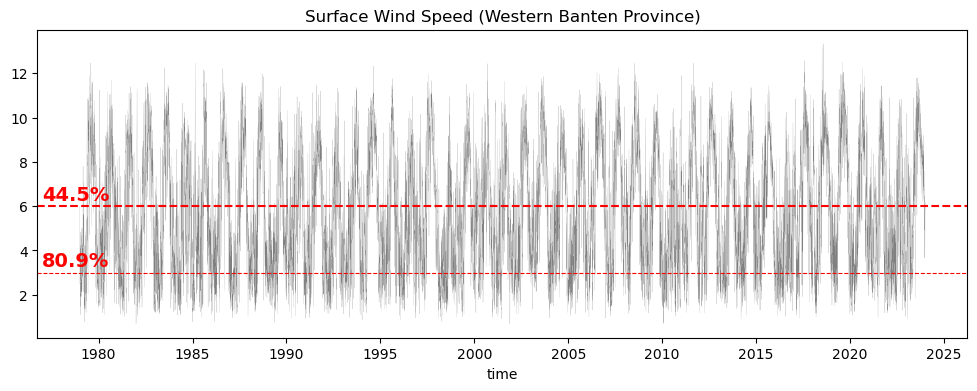

In [14]:
ax = loc_data.plot.line(color='grey', figsize=(12, 4), linewidth=0.1)
plt.title('Surface Wind Speed (Western Banten Province)')

time_above_3 = 100*((loc_data > 3).sum().item())/(loc_data.shape[0])
time_above_6 = 100*((loc_data > 6).sum().item())/(loc_data.shape[0])

plt.text(np.datetime64('1977-01-01'), 3.1, f"{time_above_3:.1f}%", color='red', fontweight='bold', fontsize=14, va='bottom')
plt.text(np.datetime64('1977-01-01'), 6.1, f"{time_above_6:.1f}%", color='red', fontweight='bold', fontsize=14, va='bottom')

plt.axhline(y=3, color='red', linestyle='--', linewidth=0.8)
plt.axhline(y=6, color='red', linestyle='--')
plt.show()

### ENSO

In [18]:
def read_nino(
    url="http://www.cpc.ncep.noaa.gov/data/indices/ersst5.nino.mth.91-20.ascii",
    ):
    """
    Read NINO data from specified web URL - assumes NOAA CPC formatting
     - old url was "http://www.cpc.ncep.noaa.gov/data/indices/ersst5.nino.mth.81-10.ascii"
    """
    #Skip header - we will specify our own
    columns=['year','month','nino1+2','nino1+2 anom','nino3','nino3 anom','nino4','nino4 anom','nino3.4','nino3.4 anom']
    nino_data = pd.read_csv(url,skiprows=1,names=columns,delim_whitespace=True)
    #output nino3.4 anomalies in required format
    nino_data['time'] = pd.to_datetime(nino_data['year'].astype(str) + nino_data['month'].astype(str).str.zfill(2), format='%Y%m') + pd.offsets.MonthEnd(0)
    nino_data.set_index('time',inplace=True)
    # remove superfluous year, month columns
    nino_data.drop(['year','month'],axis='columns',inplace=True)
    nino_data.sort_index(inplace=True)

    return nino_data


In [19]:
nino_df = read_nino()

In [20]:
nino_df['nino3.4 anom']

time
1950-01-31   -1.99
1950-02-28   -1.69
1950-03-31   -1.42
1950-04-30   -1.54
1950-05-31   -1.75
              ... 
2025-06-30   -0.07
2025-07-31   -0.14
2025-08-31   -0.36
2025-09-30   -0.47
2025-10-31   -0.53
Name: nino3.4 anom, Length: 910, dtype: float64

In [21]:
nino_df['phase'] = nino_df['nino3.4 anom'].apply(lambda x: 1 if x >= 0.8 else (-1 if x <= -0.8 else 0)) # 1 el nino # -1 la nina # 0 neutral

In [22]:
nino_df['phase'] 

time
1950-01-31   -1
1950-02-28   -1
1950-03-31   -1
1950-04-30   -1
1950-05-31   -1
             ..
2025-06-30    0
2025-07-31    0
2025-08-31    0
2025-09-30    0
2025-10-31    0
Name: phase, Length: 910, dtype: int64

In [23]:
enso_phase = xr.DataArray(data=nino_df['phase'].values, coords={'time': nino_df.index}, dims='time', name='enso')

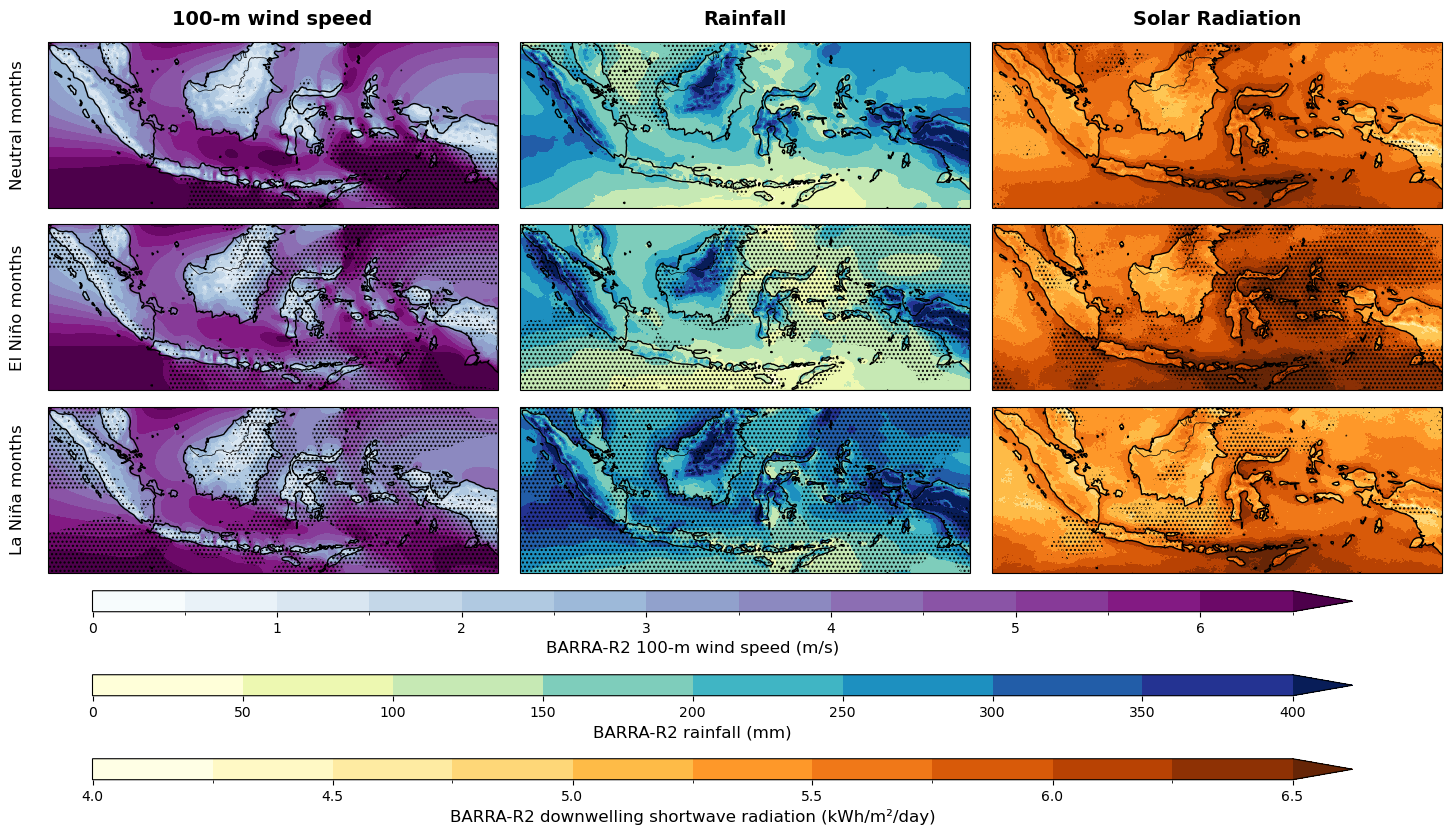

<Figure size 640x480 with 0 Axes>

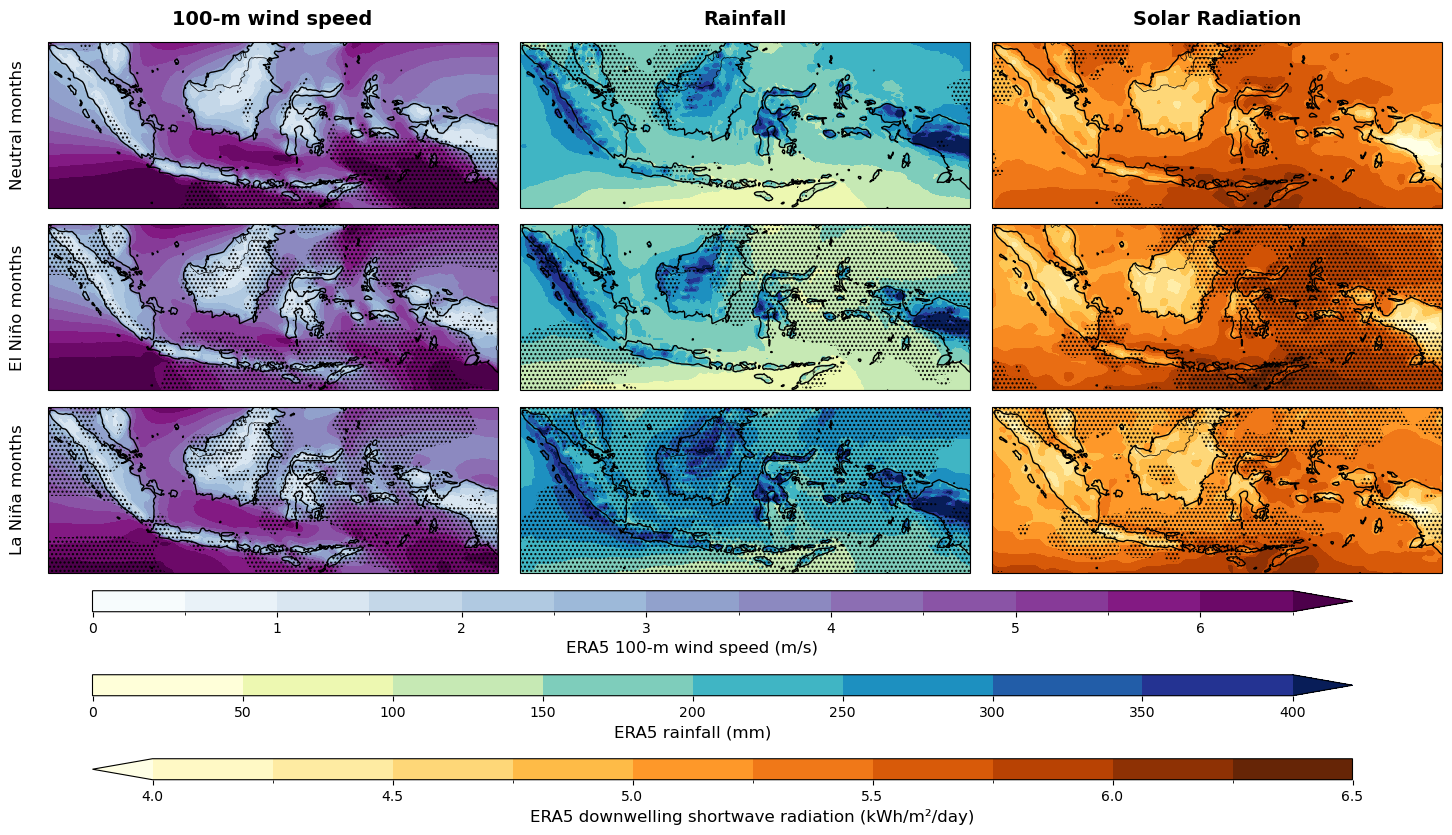

CPU times: user 43min 51s, sys: 3min 27s, total: 47min 18s
Wall time: 54min 7s


<Figure size 640x480 with 0 Axes>

In [24]:
%%time
from scipy.stats import ttest_ind

for plot_source in ['BARRA-R2', 'ERA5']:
    #ws10 = xr.Dataset({'ws10': (barra_ws10_hly.resample(time='1M')).mean()}) if plot_source == 'BARRA-R2' else xr.Dataset({'ws10': (era5_ws10_dly.resample(time='1M')).mean()})
    ws100 = xr.Dataset({'ws100': (barra_ws100_hly.resample(time='1M')).mean()}) if plot_source == 'BARRA-R2' else xr.Dataset({'ws100': (era5_ws100_dly.resample(time='1M')).mean()})
    pr = xr.Dataset({'pr': (barra_pr_hly.pr.sortby("time")*3600).resample(time='1M').sum()}) if plot_source == 'BARRA-R2' else xr.Dataset({'pr': (era5_pr_hly.tp.sortby("time")*1000).resample(time='1M').sum()}) 
    ghi = xr.Dataset({'ghi': (barra_rsds_dly.rsds*0.024).sortby('time').resample(time='D').sum()}) if plot_source == 'BARRA-R2' else xr.Dataset({'ghi': (era5_rsds_hly.ssrd.sortby("time")/(3.6e6)).resample(time='D').sum()}) #GHI units = kWh/m2 BARRA units = W/m2 #ERA5 units = J/m2

    enso_dict = {}
    enso_dict['Neutral_months-100-m_winds'] = ws100.where(enso_phase==0)
    enso_dict['El_Niño_months-100-m_winds'] = ws100.where(enso_phase==1)
    enso_dict['La_Niña_months-100-m_winds'] = ws100.where(enso_phase==-1)
    
    enso_dict['Neutral_months-rainfall'] = pr.where(enso_phase==0)
    enso_dict['El_Niño_months-rainfall'] = pr.where(enso_phase==1)
    enso_dict['La_Niña_months-rainfall'] = pr.where(enso_phase==-1)
    
    enso_dict['Neutral_months-surface_downwelling_radiation'] = ghi.where(enso_phase==0)
    enso_dict['El_Niño_months-surface_downwelling_radiation'] = ghi.where(enso_phase==1)
    enso_dict['La_Niña_months-surface_downwelling_radiation'] = ghi.where(enso_phase==-1)

    fig = plt.figure(figsize=(18, 7))
    gs = GridSpec(3, 3, figure=fig, hspace=0.05, wspace=0.05)
    axes = [fig.add_subplot(gs[i], projection=ccrs.PlateCarree()) for i in range(9)]
    
    season_order = ['Neutral_months', 'El_Niño_months', 'La_Niña_months']
    var_order = ['100-m_winds', 'rainfall', 'surface_downwelling_radiation']
    ordered_keys = []
    for season in season_order:
        for var in var_order:
            for key in enso_dict.keys():
                if season in key and var in key:
                    ordered_keys.append(key)
    
    for ax, key in zip(axes, ordered_keys):
        plot_data = enso_dict[key]
        lon2d, lat2d = np.meshgrid(plot_data.lon.values, plot_data.lat.values)
        if '100-m_winds' in key:
            t_stat, p_values = ttest_ind(plot_data.ws100.values, ws100.ws100.values, axis=0, equal_var=False, nan_policy='omit')
            significance_mask = p_values < 0.05
            wind100m = (plot_data.mean(dim='time')).ws100.plot.contourf(ax=ax, vmin=0, vmax=6.5, levels=14, transform=ccrs.PlateCarree(), cmap='BuPu', add_colorbar=False)
            ax.contourf(lon2d, lat2d, significance_mask, levels=[0.5, 1.5], hatches=['....'], colors='none', transform=ccrs.PlateCarree())
        elif 'rainfall' in key:
            t_stat, p_values = ttest_ind(plot_data.pr.values, pr.pr.values, axis=0, equal_var=False, nan_policy='omit')
            significance_mask = p_values < 0.05
            rain = (plot_data.mean(dim='time')).pr.plot.contourf(ax=ax, vmin=0, vmax=400, levels=9, transform=ccrs.PlateCarree(), cmap='YlGnBu', add_colorbar=False)
            ax.contourf(lon2d, lat2d, significance_mask, levels=[0.5, 1.5], hatches=['....'], colors='none', transform=ccrs.PlateCarree())
        elif 'surface_downwelling_radiation' in key:
            t_stat, p_values = ttest_ind(plot_data.ghi.values, ghi.ghi.values, axis=0, equal_var=False, nan_policy='omit')
            significance_mask = p_values < 0.05
            rsds = (plot_data.mean(dim='time')).ghi.plot.contourf(ax=ax, vmin=4, vmax=6.5, levels=11, transform=ccrs.PlateCarree(), cmap='YlOrBr', add_colorbar=False)    
            ax.contourf(lon2d, lat2d, significance_mask, levels=[0.5, 1.5], hatches=['....'], colors='none', transform=ccrs.PlateCarree())
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax.set_extent([domain_dict['indonesia']['lon_min'], domain_dict['indonesia']['lon_max'],
                       domain_dict['indonesia']['lat_min'], domain_dict['indonesia']['lat_max']], crs=ccrs.PlateCarree())
        ax.set_title('')
        
    col_labels = ['100-m wind speed', 'Rainfall', 'Solar Radiation']
    for j in range(3):
        axes[j].set_title(col_labels[j], fontsize=14, pad=12, fontweight='bold')
    
    row_labels = ['Neutral months', 'El Niño months', 'La Niña months']
    for i in range(3):
        ax = axes[i * 3]
        ax.text(-0.05, 0.5, row_labels[i], va='center', ha='right', rotation=90,
                fontsize=12, transform=ax.transAxes)
    
    cbar_ax = fig.add_axes([0.15, 0.06, 0.7, 0.03])  
    cbar = fig.colorbar(wind100m, cax=cbar_ax, orientation='horizontal')
    cbar.set_label(f"{plot_source} 100-m wind speed (m/s)", fontsize=12)
    
    cbar_ax = fig.add_axes([0.15, -0.06, 0.7, 0.03])  
    cbar = fig.colorbar(rain, cax=cbar_ax, orientation='horizontal')
    cbar.set_label(f"{plot_source} rainfall (mm)", fontsize=12)
    
    cbar_ax = fig.add_axes([0.15, -0.18, 0.7, 0.03])   
    cbar = fig.colorbar(rsds, cax=cbar_ax, orientation='horizontal')
    cbar.set_label(f"{plot_source} downwelling shortwave radiation (kWh/m²/day)", fontsize=12)
    
    plt.show()
    plt.clf()